In [2]:
import os
import numpy as np

import librosa
from librosa import display

import soundfile as sf
from pydub import AudioSegment
import audiosegment

import IPython.display as ipd
from matplotlib import pyplot as plt
from scipy.io import wavfile
from scipy.ndimage import shift
from scipy.signal import butter, filtfilt

/usr/local/lib/python3.8/dist-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Energy and Loudness Exploration

Energy and loudness are a parameter of audio signals that represent the loudness to humans. 

Energy can be calculated via the equation:

$$ \sum_n{|x(n)|^2}$$

Root mean square (RMS) is calculated by taking the square root of the mean energy:

 $$\sqrt{\frac{1}{N} \sum_n{|x(n)|^2}} $$

Each x(i) is the intensity of the signal in db.

##### Plot RMS only function

Plots the RMS value of the input signal.

In [4]:
def plotRMS(times, rms):
    
    fig, ax = plt.subplots(figsize=(15, 6), nrows=1)
    ax.semilogy(times, rms, label='RMS Energy')
    
    ax.legend()
    ax.label_outer() 
    ax.set(title='RMS Energy')

##### Plot Spectrogram Only Function

A Mel-Frequency spectrogram scales the y axis of a spectrogram attained through a Fourier transform to account for human's logarithmic perception of sound by converting to log-scale. 

In [5]:
def plot_Spec(times, amp_to_db):
    fig, ax = plt.subplots(figsize=(15, 6), nrows=1)
    default_x_ticks = range(len(times))
    ax.set(default_x_ticks, times)
    ax.legend()
    ax.label_outer() 
    librosa.display.specshow(amp_to_db,
                            y_axis='log',
                            x_axis='time',
                            ax=ax)
    ax.set(title='log Power spectrogram')

##### Plot RMS and Spectrogram together function

In [6]:
def plotRMS_Spec(times, rms, amp_to_db):
    fig, ax = plt.subplots(figsize=(15, 6), nrows=2, sharex=True)
    ax[0].semilogy(times, rms, label='RMS Energy')
    ax[0].set(xticks=[])
    ax[0].legend()
    ax[0].label_outer() 
    img = librosa.display.specshow(amp_to_db,
                            y_axis='log', 
                            x_axis='time', 
                            ax=ax[1])
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    ax[1].set(title='log Power spectrogram')


##### Plot RMS and Spectrogram of Hearbeat - Chase & Status

An example RMS energy and Mel-Frequency spectrogram will be shown for the song "Heartbeat" by Chase and Status. 

In [7]:
audio_data = os.getcwd() + "/Tracks/Heartbeat.mp3"
y, sr = librosa.load(audio_data)                     # Get RMS value from each frame's magnitude value
S, phase = librosa.magphase(librosa.stft(y))

rms = librosa.feature.rms(S=S) 
times = librosa.times_like(rms)
amp_to_db = librosa.amplitude_to_db(S, ref=np.max)

plotRMS_Spec(times, rms[0], amp_to_db)

/tmp/ipykernel_16789/2073928112.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_data)                     # Get RMS value from each frame's magnitude value
/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: '/rapids/notebooks/workspace/FinalProject/Explore_Workspace/Loudness/Loudness_Experiment/Tracks/Heartbeat.mp3'

### Low Pass Filter 

The bass in this song kicks in around the 40 second region. Extracting frequencies below 256 we will get the bass frequencies of the songs. This will help seperate song components in the future. 

Butter Filter tutorial followed:

https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

In [ ]:
fs = sr
T = 5.0
cutoff = 2     
n = int(T * fs)

In [ ]:
def butter_filter(data, cutoff, fs, type, order):

    if hasattr(cutoff, '__iter__'):
        normal_cutoff = []
        for cut in cutoff:
            normal_cutoff.append(cut / (fs*0.5))
    else:
        normal_cutoff = cutoff / (fs*0.5)

    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype=type, analog=False)
    y = filtfilt(b, a, data)
    return y

In [ ]:
y, sr = librosa.load(audio_data)  # Get RMS value from each frame's magnitude value
y_filt = butter_filter(y, 128, sr, "lowpass", 5)

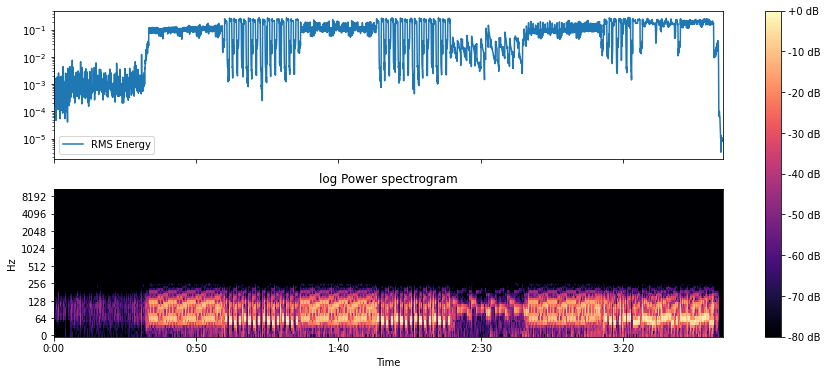

In [ ]:
S_filt, phase_filt = librosa.magphase(librosa.stft(y_filt))

rms_filt = librosa.feature.rms(S=S_filt) 
times_filt = librosa.times_like(rms_filt)
amp_to_db_filt = librosa.amplitude_to_db(S_filt, ref=np.max)

plotRMS_Spec(times_filt, rms_filt[0], amp_to_db_filt)

The order of the filter is set to 5, creating a sharp cutoff for the low frequency signals. the 0-256 range is roughly considered the lows of an audio track. It's interesting to note that the rms energy oscillates much more between the ~1 min -> ~1:30 mark. This is due to the only contribution of the track's energy being the lows which have a longer period.

### Write low pass filter data to audio file

In [ ]:
# Write out audio as 24bit Flac
sf.write('Heartbeat_Lowpass_5th-Order.flac', y_filt, sr, format='flac', subtype='PCM_24')

Almost nothing can be heard in the audio file until around 40 seconds. The result is almost no vocals can be noticed and it has a drowned out sound with only a bass guitar playing.

### High Pass Filter

In [ ]:
y, sr = librosa.load(audio_data)  # Get RMS value from each frame's magnitude value
y_high_filt = butter_filter(y, 1024, sr, "highpass", 1)

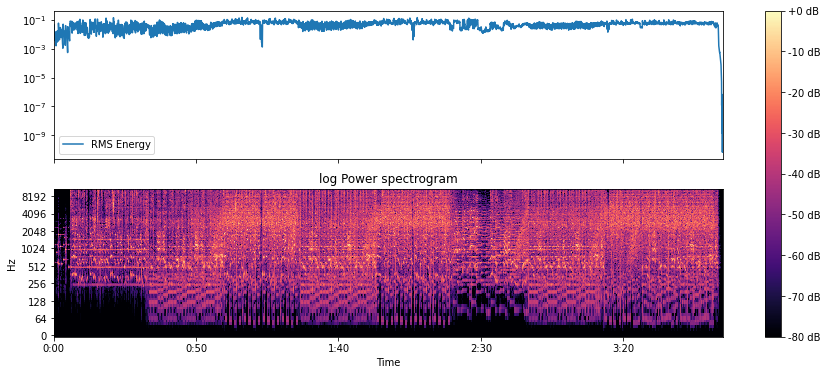

In [ ]:
S_high_filt, phase_high_filt = librosa.magphase(librosa.stft(y_high_filt))

rms_high_filt = librosa.feature.rms(S=S_high_filt) 
times_high_filt = librosa.times_like(rms_high_filt)
amp_to_db_high_filt = librosa.amplitude_to_db(S_high_filt, ref=np.max)

plotRMS_Spec(times_high_filt, rms_high_filt[0], amp_to_db_high_filt)

In [ ]:
# Write out audio as 24bit Flac
sf.write('Heartbeat_Highpass.flac', y_high_filt, sr, format='flac', subtype='PCM_24')

The sound sounds sharp with no bass. It sounds similar to how old school radios sound which could not produce bass like modern speaker systems.

### Bandpass Filter
In this experiment, a bandpass will be applied to allow an inner region while filtering the high and low frequencies out.

In [ ]:
y, sr = librosa.load(audio_data)  # Get RMS value from each frame's magnitude value

cutoff_frequencies = [512, 1024]
y_band_filt = butter_filter(y, cutoff_frequencies, sr, 'bandpass', 1)

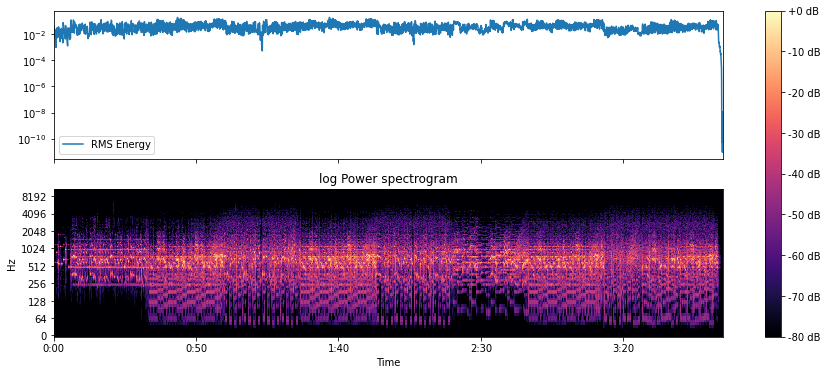

In [ ]:
S_band_filt, phase_band_filt = librosa.magphase(librosa.stft(y_band_filt))

rms_band_filt = librosa.feature.rms(S=S_band_filt) 
times_band_filt = librosa.times_like(rms_band_filt)
amp_to_db_band_filt = librosa.amplitude_to_db(S_band_filt, ref=np.max)

plotRMS_Spec(times_band_filt, rms_band_filt[0], amp_to_db_band_filt)

In [ ]:
# Write out audio as 24bit Flac
sf.write('Heartbeat_Bandpass.flac', y_band_filt, sr, format='flac', subtype='PCM_24')

The bandpass sounds like a mix of the two, with no real intense highs or lows. 

### Recombine signals

Demonstrating the recombination of signals, and the consequence of adding too much loudness to the resulting mix. This will be accomplished by adding the song to itself, exceeding the decibal limit and creating all sorts of issues with the result.

***WARNING***: If you listen to the file turn your speakers way down.

In [1]:
segment1 = audiosegment.from_numpy_array(y, sr)
segment2 = audiosegment.from_numpy_array(y, sr)

combined_segments = segment1 + segment2
#combined_segments.export("Heartbeat_Doubled.flac", format="flac")

NameError: name 'audiosegment' is not defined

### Convert Librosa <--> PyDub

In [ ]:
# pydub audiosegment to librosa
combined_segments_np_lib = np.array(combined_segments.get_array_of_samples(), dtype=np.float32) # Librosa uses float32
# b_p = np.array(b* (1<<15), dtype=np.int16)  # PyDub usees int16

In [ ]:
S_doubled, phase_doubled = librosa.magphase(librosa.stft(combined_segments_np_lib))

rms_doubled = librosa.feature.rms(S=S_doubled) 
times_doubled = librosa.times_like(rms_doubled)
amp_to_db_doubled = librosa.amplitude_to_db(S_doubled, ref=np.max)

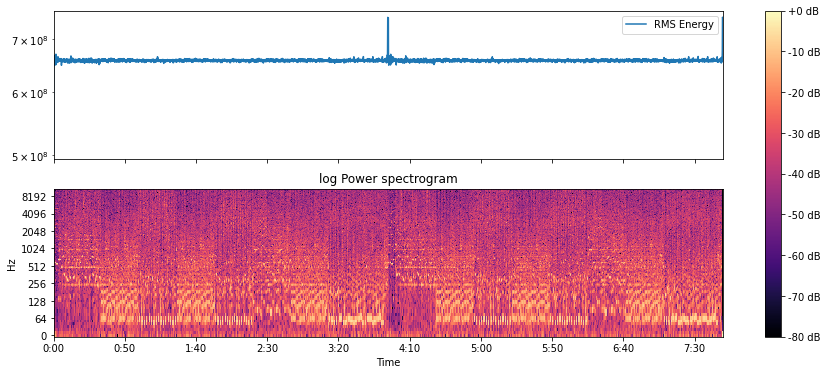

In [ ]:
plotRMS_Spec(times_doubled, rms_doubled[0], amp_to_db_doubled)

You can see here that the entire region is almost at the max decibal level. The resulting mix is very unpleasant.

In [ ]:
# Write out audio as 24bit Flac
sf.write('Heartbeat_Super_Imposed.flac', y_band_filt, sr, format='flac', subtype='PCM_24')

## References

https://towardsdatascience.com/get-to-know-audio-feature-extraction-in-python-a499fdaefe42

https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7
